Objective: Using PCA to classify different periods of the 24-hour EEG recording. 

How?: By dividing the EEG time series in non-overlapping pieces of 3,000 data points.

EEG Hz = 100, in 30 secs, EEG contains = 3000 data. 

coeff: the weights of each principal component in the original axes,

score: the data already projected on the rotated axes 

latent: how much variance is explained by each of the principal components.

    

In [3]:
import scipy.io
from numpy import *
import numpy as np
import matplotlib 
from matplotlib.mlab import *
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.signal import periodogram, welch, spectrogram

#from matplotlib.mlab import PCA



% matplotlib inline

data = loadmat("eeg.mat")
hd,hdh=data['hd'],data['hdh']
rec,rech=data['rec'],data['rech'][0]

def pca(A):
    M = (A-mean(A.T,axis=1)).T
    [latent,coeff] = linalg.eig(cov(M))
    score = dot(coeff.T,M) 
    return coeff,score,latent

### Exercise 1

a) Build a matrix that contains in each row each successive segment of data of length 3,000. This matrix will have dimensions length(rech) x 3,000. To correct for possible drifts in the mean EEG signal, subtract from each of these segments its mean.


In [4]:
fs = 100 # EEG was acquired at 100 Hz

data = rec[1,:] # EEG recording


eeg = data.reshape(len(rech)-1,3000) # The EEG matrix 
# print(data.size) prints 8490000, dividing it to 3000 gives me 2830. 
# however, print (len(rech)) is equal to 2831, that's why I subtracted 1 from len(rech)

print(eeg.shape)
print(data.size)
print(len(rech))
print(int((data.size)/3000))

row_means = np.mean(eeg, axis=1) # Mean across the second (column) axis

eeg_new = (eeg.transpose()-row_means).transpose() # I have used transpose function to subtract because the leading axes had the same dimension but not trailing axes. 

#print (eeg)
#print (eeg_new)


(2830, 3000)
8490000
2831
2830


b) Compute the power spectrum with pwelch. You can let Matlab/Python choose the default window size and sampling frequency, because we do not need that info now. We save the resulting power spectrum in decibels (i.e. we take the logarithm in base 10, log10, and multiply the result by 10) in a new matrix that will include all these spectra as different rows, and thus it will have dimensions length(rech) x length(power spectrum).

In [4]:
teeg =np.transpose(eeg_new) #transpose of EEG
F, Pxx = welch(teeg)
print (Pxx.shape)

spect = np.log10(Pxx)*10  #decibels

spect_new = np.transpose(spect)

print (spect_new.shape) # this gives dimensions 3000 x len(powerspectrum) rather than len(rech)x len(powerspectrum)

#That's why I tried to work on the code without transpose.

(3000, 129)
(129, 3000)


In [5]:
F, Pxx = welch(eeg_new)

print (Pxx.shape)

spect = np.log10(Pxx)*10  #decibels

print (spect.shape)

# Here, without transpose, it gives the dimensions of len(rech)x len(powerspectrum)

(2830, 129)
(2830, 129)


c) Now you are ready to pass this information to the PCA algorithm. First, though, see by yourself what the data looks like. Plot individual power spectra (from different random rows in your matrix) and see that they are messy and potentially different from one another in specific ways. In what ways? What are the essential differences that collectively separate these different spectra in separate classes that could signal different brain states? This is what PCA allows us to do.


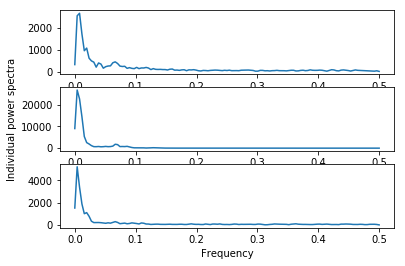

In [312]:
plt.subplot(311)
plt.plot(F,Pxx[35])

plt.subplot(312)
plt.plot(F,Pxx[1132])
plt.ylabel('Individual power spectra')

plt.subplot(313)
plt.plot(F,Pxx[162])

plt.xlabel('Frequency') ; 
plt.show()
# Min/Max power levels as well as the power varience differs greatly between random points!
#plt.xlim(0,0.1)

### Exercise 2

a) Run the PCA with princomp on the power spectra matrix and first plot the percent of variance explained by each principal component. How many components do you think are necessary to sufficiently explain the data?

1st principle variance: 89.2624095114 %
2nd principle variance: 3.93658440396 %
3rd principle variance: 1.50504978252 %


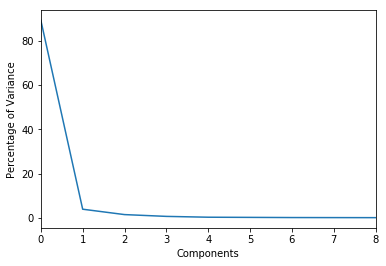

In [52]:
[coeff, score, latent] = pca(spect)
plt.plot(latent/sum(latent)*100) 
plt.xlim(0,8)
plt.ylabel("Percentage of Variance")
plt.xlabel("Components")

print("1st principle variance: " + str(latent[0]/sum(latent)*100) + " %")
print("2nd principle variance: " + str(latent[1]/sum(latent)*100) + " %")
print("3rd principle variance: " + str(latent[2]/sum(latent)*100) + " %")

# 1st component makes up the majority of the variance, 
# 2nd component is also significant; 
# first 2 components are enough to explain the data!


b) Plot in a 2D graph each data point in the first and second principal components (see Fig 1). What do you see? Could you easily separate the two main brain states, awake and asleep from this representation?


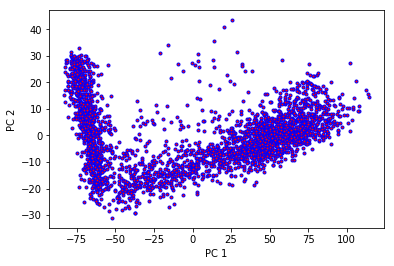

In [200]:
plt.scatter(score[0],score[1], c="r", marker='.', edgecolors="b", )

plt.xlabel("PC 1") ; plt.ylabel("PC 2")

plt.show()
# 2 clusters of data visibly different from each other.

c) Which PC do you think would be better to separate these two clouds?  Separate the two clouds based on a fixed value in the first principal component and average the spectra for all EEG pieces at each side of this boundary separately (see Fig 2). Plot each of these two mean power spectra. Can you identify what cloud corresponds to the awake state and what cloud is more consistent with sleep?


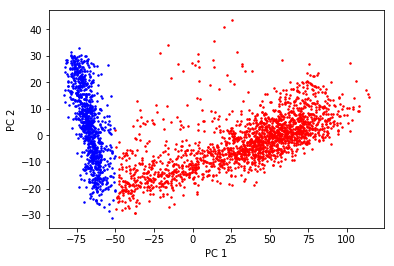

In [313]:
seperation_point = sp = -50 

p1=np.where(score[0] >= sp) ; p2=np.where(score[0] < sp)

plt.plot(score[0][p1],score[1][p1],'.',markersize=3,color='r')
plt.plot(score[0][p2],score[1][p2],'.',markersize=3,color='b')
plt.xlabel('PC 1') ; plt.ylabel('PC 2')

plt.show()


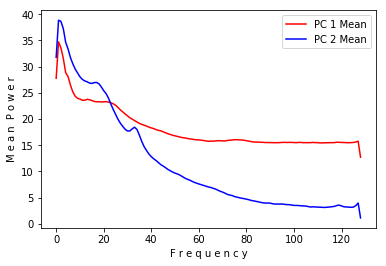

In [314]:
mean_p1 = mean(spect[p1], axis=0) # Taking the average of all data point belonging to p1 and p2 seperately 
mean_p2 = mean(spect[p2], axis=0)

plt.plot(mean_p1, c='red', label="PC 1 Mean") 
plt.plot(mean_p2, c='blue', label="PC 2 Mean")

plt.legend()

plt.xlabel('F r e q u e n c y')
plt.ylabel('M e a n  P o w e r')

plt.show()

# PCA 2 represents sleep state while PCA 1 represents awake state

### Exercise 3

a) Knowing that the sleep phase contains separate brain states (REM, shallow NON-REM, deep NON-REM), you can try to see if PCA can distinguish those states by looking at the 2nd principal component. First zoom in your sleep cloud in the score plot and see if you can identify separate sub-clouds. Plot a histogram of the 2nd component score for the sleep points and see if you can identify separate subgroups. Do you see different modes on the distribution you got with the histogram?


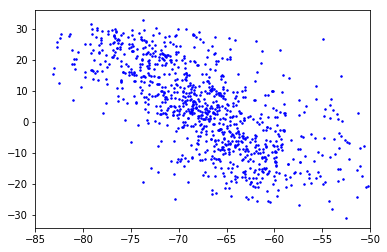

In [208]:

plt.plot(score[0][p2],score[1][p2],'.',markersize=3,color='b')

plt.xlim(-85,-50)

plt.show()


Text(0.5,1,'Histogram of Sleep Cluster')

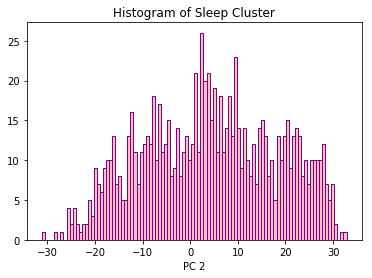

In [251]:
plt.hist(score[1][p2], bins=100, color="pink", edgecolor="purple")
plt.xlabel('PC 2')
plt.title("Histogram of Sleep Cluster")


b) Perhaps you do not see very clearly the separation. The next thing you can do is to run again the PCA now restricted to the sleep spectra you identified in Exercise 2. This is a more powerful approach because, as mentioned in class, the 2nd component is forced to be orthogonal to the 1st component. In this new analysis this constraint is removed and now the direction that best distinguishes the sleep conditions can be evaluated without such restrictions. In this new PCA, plot now the fraction of explained variance in the two first principal components. Can you distinguish now 3 clouds? Can you visually determine the boundaries of each sleep phase? Use the histogram again. Try diferent number of bins and extract the boundaries from here (Fig. 3). Using such boundaries you can now separate spectra corresponding to each cloud and average them together to obtain 3 mean spectra for each clouds. Plot them (Fig. 4). Can you identify  the REM, shallow NON-REM, and deep NON-REM phases of sleep?


1st principle variance: 49.0305252127 %
2nd principle variance: 10.0998093185 %
3rd principle variance: 6.22729036745 %
4th principle variance: 3.58345251577 %
5th principle variance: 2.11362175389 %


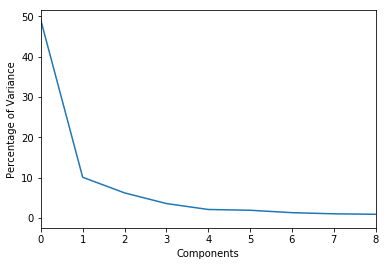

In [217]:
sleep_spect = spect[p2] #Seperating sleeping data points

[coeff_2, score_2, latent_2] = pca(sleep_spect) #PCA on sleep data points

plt.plot(latent_2/sum(latent_2)*100) #Plotting percentages of principal components
plt.xlim(0,8)
plt.ylabel("Percentage of Variance"); plt.xlabel("Components")

print("1st principle variance: " + str(latent_2[0]/sum(latent_2)*100) + " %")
print("2nd principle variance: " + str(latent_2[1]/sum(latent_2)*100) + " %")
print("3rd principle variance: " + str(latent_2[2]/sum(latent_2)*100) + " %")
print("4th principle variance: " + str(latent_2[3]/sum(latent_2)*100) + " %")
print("5th principle variance: " + str(latent_2[4]/sum(latent_2)*100) + " %")


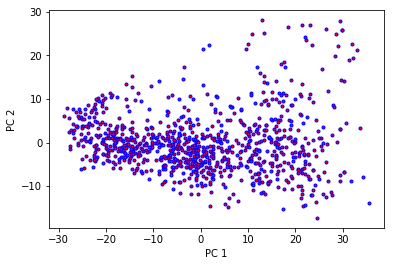

In [218]:
plt.scatter(score_2[0],score_2[1], c="r", marker='.', edgecolors="b", )

plt.xlabel("PC 1") ; plt.ylabel("PC 2")

plt.show()
# There seems to be a faint seperation around -10 and +10 points

(-20, 20)

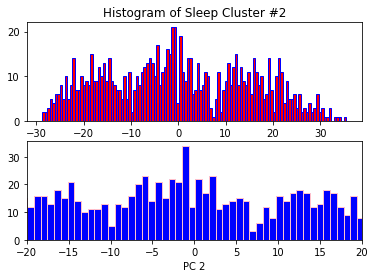

In [252]:
plt.subplot(211)
plt.hist(score_2[0], bins=120, color="red", edgecolor="blue")
plt.xlabel('PC 2')
plt.title("Histogram of Sleep Cluster #2")
plt.subplot(212)
plt.hist(score_2[0], bins=80, color="blue", edgecolor="pink")
plt.xlabel('PC 2')
plt.xlim(-20,+20)

#There indeed are 3 different sub-clouds, seperated at -10 and +7

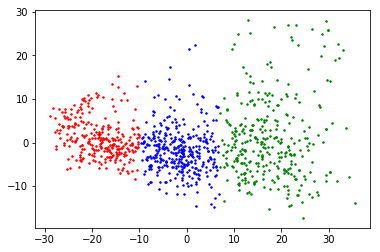

In [255]:
sps1 = -10 #Defining seperation points
sps2 = 7 

s1 = np.where(score_2[0] < sps1) #Seperating data according to conditions
s2 = np.where((score_2[0] >= sps1)&(score_2[0]< sps2))
s3 = np.where(score_2[0] >= sps2)

plt.plot(score_2[0][s1],score_2[1][s1],'.',markersize=3,color='r')
plt.plot(score_2[0][s2],score_2[1][s2],'.',markersize=3,color='b')
plt.plot(score_2[0][s3],score_2[1][s3],'.',markersize=3,color='g')

plt.show()


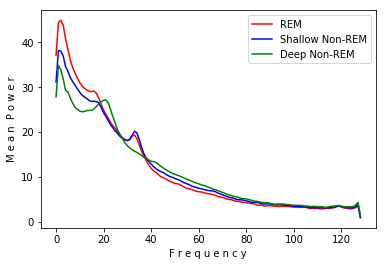

In [259]:
mean_s1 = mean(sleep_spect[s1], axis=0) # Taking the average of all data point belonging to p1 and p2 seperately 
mean_s2 = mean(sleep_spect[s2], axis=0)
mean_s3 = mean(sleep_spect[s3], axis=0)

plt.plot(mean_s1, c='red', label="REM") 
plt.plot(mean_s2, c='blue', label="Shallow Non-REM")
plt.plot(mean_s3, c="green", label="Deep Non-REM")
plt.legend()

plt.xlabel('F r e q u e n c y')
plt.ylabel('M e a n  P o w e r')

plt.show()


c) You have now achieved your own classification of the phases of sleep-wake in this recording. Let's see how well we did in identifying sleep phases on our own, just with the help of the PCA algorithm, compared with the expert eye recorded in the hypnogram rech. To this end, get the indices that rech attributes to the REM stage, to the NON-REM stages 1 and 2, and to the NON-REM stages 3 and 4. Then plot again the 2D plot of PC1 against PC2 for the two cases before (all spectra, and sleep-spectra alone), only that the dots are plotted with different color depending on the rech evaluation. Check Figure 5 and 6. Pretty good, eh?

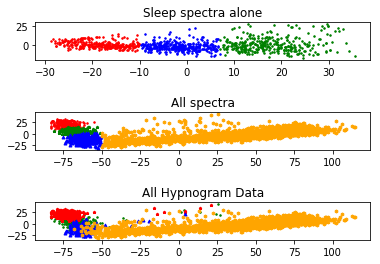

In [302]:
plt.subplot(511)
plt.title('Sleep spectra alone')

plt.plot(score_2[0][s1],score_2[1][s1],'.',markersize=3,c="r")
plt.plot(score_2[0][s2],score_2[1][s2],'.',markersize=3,c="b")
plt.plot(score_2[0][s3],score_2[1][s3],'.',markersize=3,c="g")

plt.subplot(513)
plt.title('All spectra')

plt.plot(score[0][p2][s1], score[1][p2][s1],'.',markersize=3,c='r')
plt.plot(score[0][p2][s2], score[1][p2][s2],'*',markersize=3,c='g')
plt.plot(score[0][p2][s3], score[1][p2][s3],'^',markersize=3,c='blue')
plt.plot(score[0][p1], score[1][p1],'h',markersize=3,c='orange')

plt.subplot (515)
plt.title('All Hypnogram Data')

nrem1= np.where(np.logical_or(rech==1,rech==2))
nrem2= np.where(np.logical_or(rech==3,rech==4))
rem= np.where(rech==5)
awake= np.where(np.logical_or(rech==0,rech==6))

plt.plot(score[0][nrem1],score[1][nrem1], '.', markersize=3, c='g')
plt.plot(score[0][nrem2],score[1][nrem2], '*', markersize=3, c='r')
plt.plot(score[0][rem],score[1][rem], '^', markersize=3, c='blue')
plt.plot(score[0][awake],score[1][awake],'h', markersize=3, color='orange')

plt.show()

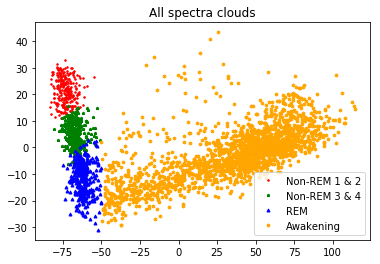

In [295]:
plt.title('All spectra clouds') #Including Legend
plt.plot(score[0][p2][s1], score[1][p2][s1],'.',markersize=3,c='r', label ="Non-REM 1 & 2")
plt.plot(score[0][p2][s2], score[1][p2][s2],'*',markersize=3,c='g', label ="Non-REM 3 & 4")
plt.plot(score[0][p2][s3], score[1][p2][s3],'^',markersize=3,c='blue', label ="REM")
plt.plot(score[0][p1], score[1][p1],'h',markersize=3,c='orange', label ="Awakening")
plt.legend()
plt.show()

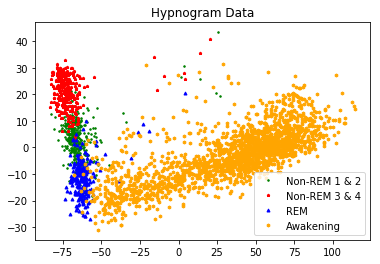

In [294]:
plt.title('Hypnogram Data') #Including Legend

nrem1= np.where(np.logical_or(rech==1,rech==2))
nrem2= np.where(np.logical_or(rech==3,rech==4))
rem= np.where(rech==5)
awake= np.where(np.logical_or(rech==0,rech==6))

plt.plot(score[0][nrem1],score[1][nrem1], '.', markersize=3, c='g', label ="Non-REM 1 & 2")
plt.plot(score[0][nrem2],score[1][nrem2], '*', markersize=3, c='r', label ="Non-REM 3 & 4")
plt.plot(score[0][rem],score[1][rem], '^', markersize=3, c='blue', label ="REM")
plt.plot(score[0][awake],score[1][awake],'h', markersize=3, color='orange', label="Awakening")
plt.legend()
plt.show()